In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

The first exclamation mark in the next cell serves to tell jupyter to execute it as a bash command.

In [2]:
![ ! -f "../../model-zoo/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" ] && printf "weight hasn't been downloaded."

In [3]:
%%bash
file="inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
dir="../../model-zoo/"
mkdir -p $dir
if [ -f "$dir$file" ]; then
  printf "Weight $file already downloaded.\nNormally, you can proceed to the next cell.\nIn case of problems, please check inside $dir or re-download it.\n"
else
  printf "Downloading $file from google...\n";
  wget "https://storage.googleapis.com/mledu-datasets/$file" -O "$dir$file" 2>&1
fi

Weight inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 already downloaded.
Normally, you can proceed to the next cell.
In case of problems, please check inside ../../model-zoo/ or re-download it.


<code><b>%%bash</b></code> will make the cell into something like a script whose stdout being the stdout of the cell. For example,

In [4]:
%%bash
ls
pwd

01_a-conversation-with-andrew-ng.mp4
02_understanding-transfer-learning-the-concepts.mp4
03_Course-2-Part-6-Lesson-3-Notebook.ipynb
03_ours.ipynb
04_coding-transfer-learning-from-the-inception-mode.mp4
06_coding-your-own-model-with-transferred-features.mp4
08_exploring-dropouts.mp4
09_applying-transfer-learning-to-cats-v-dogs_Course_2_-_Part_6_-_Lesson_3_-_Notebook.ipynb
10_exploring-transfer-learning-with-inception.mp4
12_week-3-wrap-up.mp4
corbeille
srt-ss-titre
trash.py
txt-ss-titre
/home/phunc20/samsung-SATA/mooc/coursera/deeplearning.ai/tf-in-practice/02_convolutional-neural-networks-tensorflow/03_transfer-learning/01_transfer-learning


In [5]:
local_weights_file = '../../model-zoo/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

I think we could have spare us from using the <code><b>load_weights()</b></code> method, couldn't we?

In [6]:
weights_file = '../../model-zoo/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained = InceptionV3(input_shape=(150, 150, 3), 
                               include_top=False, 
                               weights=weights_file)

for layer in pretrained.layers:
    layer.trainable = False
    
pretrained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

__________________________________________________________________________________________________
activation_141 (Activation)     (None, 7, 7, 160)    0           batch_normalization_141[0][0]    
__________________________________________________________________________________________________
average_pooling2d_13 (AveragePo (None, 7, 7, 768)    0           mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 7, 7, 192)    147456      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 7, 7, 192)    215040      activation_136[0][0]             
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 7, 7, 192)    215040      activation_141[0][0]             
__________

Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
last_output

last layer output shape:  (None, 7, 7, 768)


<tf.Tensor 'mixed7/Identity:0' shape=(None, 7, 7, 768) dtype=float32>

In [9]:
last_layer.input_shape

[(None, 7, 7, 192), (None, 7, 7, 192), (None, 7, 7, 192), (None, 7, 7, 192)]

In [10]:
last_layer.input

[<tf.Tensor 'activation_60/Identity:0' shape=(None, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_63/Identity:0' shape=(None, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_68/Identity:0' shape=(None, 7, 7, 192) dtype=float32>,
 <tf.Tensor 'activation_69/Identity:0' shape=(None, 7, 7, 192) dtype=float32>]

In [11]:
from tensorflow.keras.optimizers import RMSprop

In [12]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

In [13]:
x

<tf.Tensor 'flatten/Identity:0' shape=(None, 37632) dtype=float32>

In [16]:
import numpy as np
np.product(last_output.shape[1:])

37632

In [17]:
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [18]:
ls ../../

01_exploring-a-larger-dataset/                     cats_and_dogs_filtered.zip
02_augmentation-a-technique-to-avoid-overfitting/  cats-N-dogs/
03_transfer-learning/                              dl
04_multiclass-classifications/                     model-zoo/


In [23]:
!tree -L 3 ../../../datasets/

../../../datasets/
└── cats_and_dogs_filtered
    ├── train
    │   ├── cats
    │   └── dogs
    ├── validation
    │   ├── cats
    │   └── dogs
    └── vectorize.py

7 directories, 1 file


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '../../../datasets/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 282s - loss: 0.3590 - accuracy: 0.8540 - val_loss: 0.1029 - val_accuracy: 0.9610
Epoch 2/20
100/100 - 251s - loss: 0.2303 - accuracy: 0.9155 - val_loss: 0.0969 - val_accuracy: 0.9660
Epoch 3/20
100/100 - 252s - loss: 0.2008 - accuracy: 0.9195 - val_loss: 0.1789 - val_accuracy: 0.9380
Epoch 4/20
100/100 - 231s - loss: 0.1883 - accuracy: 0.9285 - val_loss: 0.0966 - val_accuracy: 0.9710
Epoch 5/20
100/100 - 230s - loss: 0.1840 - accuracy: 0.9295 - val_loss: 0.1474 - val_accuracy: 0.9550
Epoch 6/20
100/100 - 234s - loss: 0.1684 - accuracy: 0.9370 - val_loss: 0.1119 - val_accuracy: 0.9650
Epoch 7/20
100/100 - 238s - loss: 0.1887 - accuracy: 0.9330 - val_loss: 0.1207 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 241s - loss: 0.1630 - accuracy: 0.9440 - val_loss: 0.0945 - val_accuracy: 0.9680
Epoch 9/20
100/100 - 212s - loss: 0.1715 - accuracy: 0.9355 - val_loss: 0.0924 - val_accuracy: 0.9710
Epoch 10/20
100/100 - 212s - loss: 0.1527 - accuracy: 0.9490 - val_loss: 0.0970 - 

In [26]:
model.save("avec-dropout.h5")

In [29]:
ls *.h5

avec-dropout.h5


In [30]:
!du -hsx *.h5

329M	avec-dropout.h5


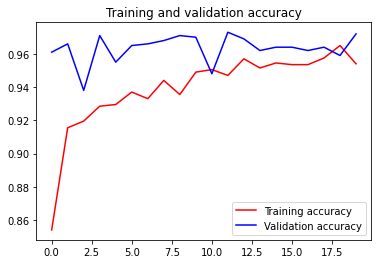

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()